 [Raphaël Bennaim](https://github.com/raphrb2) et [Bastien Hoorelbeke](https://github.com/bast-94)

# Initiation aux réseaux de neurones

In [85]:
import tensorflow as tf
import numpy as np  # linear algebra
import pandas as pd
import matplotlib.pyplot as plt  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.image as mpimg
import math
from IPython.display import FileLink
import yaml
import random
import glob
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Importation des modules de Tensorflow et de Keras.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
    BatchNormalization,
    LeakyReLU,
)
from tensorflow.keras.models import load_model

In [ ]:
num_classes = 10
SEED = 25
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTPUT_DIR = "/kaggle/working/outputs"
strategy = tf.distribute.MirroredStrategy()

Dans le but de pouvoir garder une trace des paramètres et hyperparamètres des modèles entrainés, un fichier `config.yml` est créé et les paramètres seront enregistrés au cours de l'exécution.

In [86]:
def save_config(dictionnaire, chemin_fichier="config.yml"):
    with open(chemin_fichier, "w") as fichier:
        yaml.dump(dictionnaire, fichier)
    print("Fichier YAML sauvegardé avec succès.")


def read_yaml(chemin_fichier):
    if os.path.exists(chemin_fichier):
        with open(chemin_fichier, "r") as fichier:
            contenu = yaml.safe_load(fichier)
    else:
        contenu = {}
    return contenu

In [87]:
config = {}

On enregistre d'abord les hyperparamètres du modèle dans le fichier `config.yml` puis on enregistre les paramètres du modèle dans un fichier dédié.

In [88]:
config["output_file"] = "submission.csv"
config["BATCH_SIZE"] = 128
config["model_file"] = "best_model.h5"
config["epochs"] = 200

## Affichage des images

On commence par afficher quelques images pour se faire une idée des images que nous allons traiter.

In [89]:
directory_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data/"

In [90]:
def get_subdirs(directory_path):
    return next(os.walk(directory_path))[1]


def get_files_list(directory_path):
    return next(os.walk(directory_path))[2]

Le but est d'afficher chaque catégorie d'image.

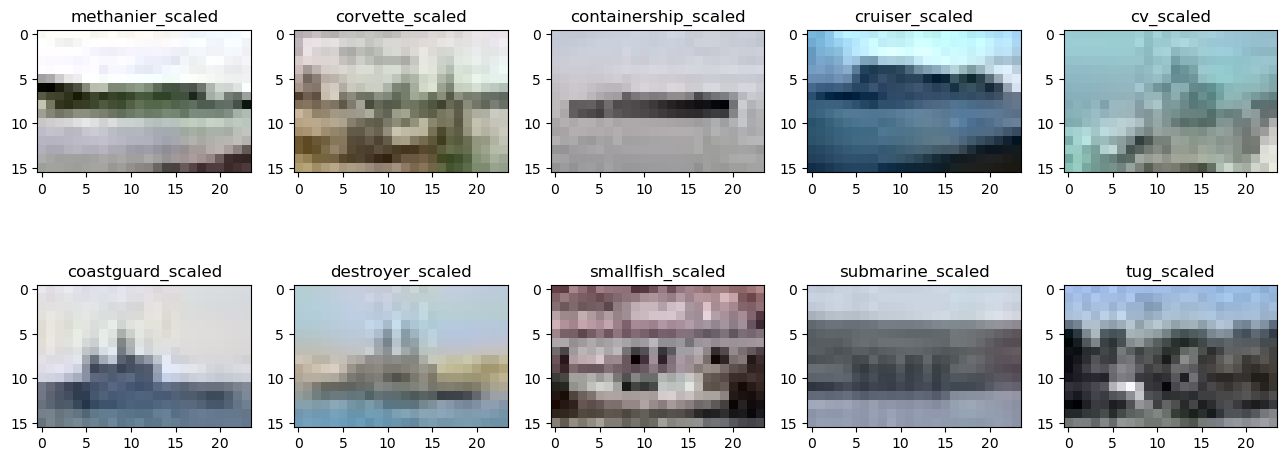

In [91]:
def display_images(directory_path, figsize=(8, 8)):
    sub_dirlist = get_subdirs(directory_path)
    fig = plt.figure(figsize=figsize)
    cols, rows = 5, 5
    for i in range(len(sub_dirlist)):
        sub_dir = sub_dirlist[i]
        full_path_dir = os.path.join(directory_path, sub_dir)
        img_path = random.choice(get_files_list(full_path_dir))
        img_path = os.path.join(full_path_dir, img_path)
        img = mpimg.imread(img_path)
        fig.add_subplot(rows, cols, i + 1)
        plt.title(f"{sub_dir}")
        plt.imshow(img)
    plt.show()


figsize = (16, 16)
display_images(directory_path, figsize)

## Générer le dataset depuis les images

cf https://keras.io/api/data_loading/image/ et 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

Nous allons d'abord charger les images depuis le dossier `data` pour en générer des datasets tensorflow qui seront pratiquables par notre modèle.

In [92]:
ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    labels="inferred",
    subset="both",
    shuffle=True,
    validation_split=0.2,
    seed=SEED,
    image_size=(16, 24),
    batch_size=config["BATCH_SIZE"],
)
ds_train

Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Using 7103 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [93]:
ds_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Résultat à soumettre

Au cours de l'entraînement de notre modèle, il est préférable de fixer des conditions d'arrêt pour éviter de trop entraîner notre modèle et de le faire overfitter.

On définit `MyCustomCallback` qui va sauvegarder le modèle à chaque fois que la val_loss est minimale.

In [94]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, **kwargs):
        self.patience = patience
        self.counter = 0
        self.min_val_loss = float("inf")
        self.model_file_path = kwargs["model_file"]

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            print(f"\nNew Mininimum for validation loss: {self.min_val_loss}")
            print(f"Saving {self.model_file_path}, {epoch = }")
            self.model.save(os.path.join(self.model_file_path))

Nous définissons une condition d'arrêt lorsqu'une limite de temps `time_limit` est atteinte.

In [95]:
class TimeOutCallback(tf.keras.callbacks.Callback):
    def __init__(self, time_limit, **kwargs):
        self.beginning_time = time()
        self.time_limit = time_limit

    def on_epoch_end(self, epoch, logs=None):
        current_time = time()
        d_time = current_time - self.beginning_time
        if d_time >= self.time_limit:
            self.model.stop_training = True

Nous définissons une fonction qui va effectuer des inférencses sur un jeu de données que le modèle n'a jamais traité.

In [96]:
def test_phase(model):
    file_name = config["output_file"]
    X_test = np.load("/kaggle/input/navires-2023-la-mano/test.npy", allow_pickle=True)
    X_test = X_test.astype("float32")
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category": res})
    df.to_csv(os.path.join(file_name), index_label="Id")

Nous définissons des fonctions qui vont nous permettre de sauvegarder l'historique d'entraînement dans des fichiers csv.

In [ ]:
def save_history(model, history):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"history.csv"
    history_df.to_csv(os.path.join(hist_file_name))


def save_model(model):
    model_file_name = f"{model.name}.h5"
    model.save(os.path.join(model_file_name))

## Créer le modèle

Passons ensuite à la création du modèle.

In [97]:
def build_model(input_shape=(16, 24, 3), num_classes=10) -> Model:
    model = Sequential(
        [
            Conv2D(128, 5, padding="same", input_shape=input_shape, activation="relu"),
            LeakyReLU(alpha=0.1),
            BatchNormalization(),
            Dropout(0.45),
            Conv2D(128, (3, 3), padding="same", activation="relu"),
            LeakyReLU(alpha=0.1),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.5),
            Conv2D(128, (3, 3), padding="same", activation="relu"),
            LeakyReLU(alpha=0.1),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.7),
            Flatten(),
            Dense(256, activation="relu"),
            LeakyReLU(alpha=0.6),
            BatchNormalization(),
            Dropout(0.675),
            Dense(num_classes, activation="softmax"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    return model


with strategy.scope():
    model = build_model()
config["model_config"] = model.get_config()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 24, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 24, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 24, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 24, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 24, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 24, 128)       0         
                                                        

## Lancer le modèle

Afin d'avoir une allure de l'évolution de l'entraînement nous allons définir la fonction `plot_history` qui va nous permettre de tracer les courbes d'évolution de la loss et de la val_loss.	

In [98]:
def plot_history(history=None, file_name=None):
    if file_name is None:
        history_df = pd.DataFrame(history.history)
    else:
        history_df = pd.read_csv(file_name)
    history_df[["val_accuracy", "accuracy"]].plot()
    plt.show()
    history_df[["loss", "val_loss"]].plot()
    plt.show()

Nous entraînons ensuite notre modèle.

In [124]:
BEST_MODEL_FILE_NAME = "model.h5"


def train_and_test(model=None, **kwargs):
    callbacks = []
    epochs = kwargs["epochs"]
    callbacks.append(MyCustomCallback(**kwargs))
    callbacks.append(
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, verbose=1)
    )
    callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
            BEST_MODEL_FILE_NAME, verbose=1, save_best_only=True
        )
    )
    if model is None:
        model = build_model()
    history = model.fit(
        ds_train, epochs=epochs, validation_data=ds_val, callbacks=callbacks
    )
    test_phase(model)
    save_model(model)
    save_history(model, history)
    return history

Entrainement du modèle, selon les configurations fixées antérieurment.

In [102]:
history = train_and_test(model, **config)

222/222 [==============================] - ETA: 0s - loss: 2.2760 - accuracy: 0.2741
New Mininimum for validation loss: 1.85978102684021
Saving best_model.h5, epoch = 0

Epoch 1: val_loss improved from inf to 1.85978, saving model to model_.h5
116/116 [==============================] - 7s 59ms/step


Sauvegarde du modèle

### Analyse des résultats de l'entrainement

In [136]:
model = load_model(BEST_MODEL_FILE_NAME)

Afin de pouvoir analyser les résultats de l'entraînement, nous allons afficher les matrices de confusion de notre modèle lorsque celui-ci s'applique sur les données de validation.

In [137]:
def get_confusion_matrix(model, ds_val):
    val_predictions = model.predict(ds_val)

    val_predicted_classes = tf.argmax(val_predictions, axis=1)

    val_true_classes = tf.concat([y for x, y in ds_val], axis=0)

    return confusion_matrix(val_true_classes, val_predicted_classes)


def display_confusion_matrix(val_confusion_matrix):
    # Matrice de confusion pour l'ensemble de validation
    plt.figure(figsize=(10, 8))
    sns.heatmap(val_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - Validation")
    plt.xlabel("Prédictions")
    plt.ylabel("Valeurs réelles")

    plt.show()

#### Calcul le la matrice de confusion

In [138]:
val_confusion_matrix = get_confusion_matrix(model, ds_val)

56/56 [==============================] - 11s 201ms/step


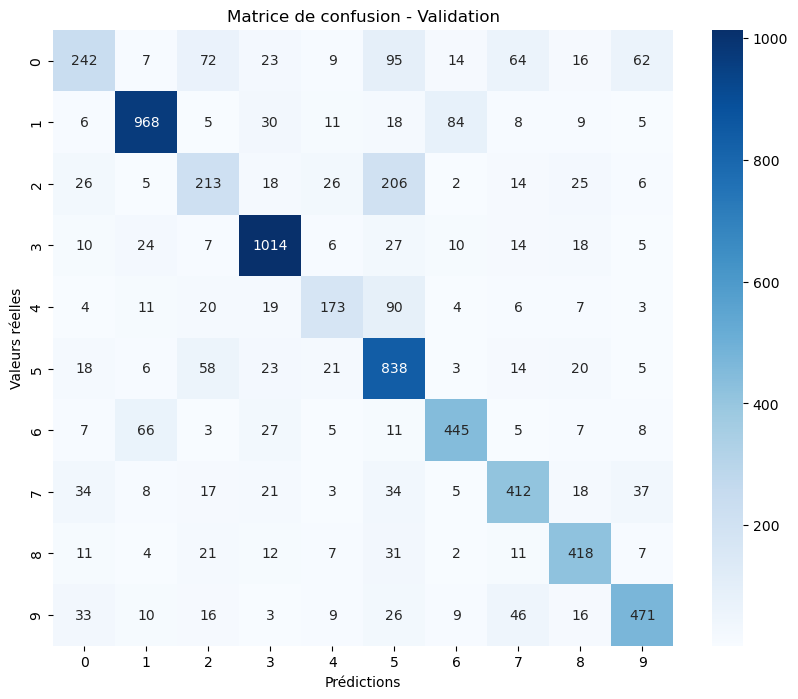

In [139]:
display_confusion_matrix(val_confusion_matrix)

Dans l'ensemble on observe que la diagonale a la plus grande intensité, ce qui montre que le modèle sait plutôt bien gérer les vrais positifs.
On remarque que notre modèle prédit correctement les images de classes 3, cependant il est quelque peu confus lorsqu'il s'agit de prédire les images de la classe 5. 

#### Calcul des précisons et recall



Nous allons ici afficher sous forme d'histogramme nos recall et précision pour chaque classe.

In [132]:
def precision_recall(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP

        precision[i] = TP / (TP + FP)
        recall[i] = TP / (TP + FN)

    return precision, recall


def plot_histogram(data, class_names, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, data)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()


def compute_and_display_pr(val_confusion_matrix):
    class_names = [f"{i}" for i in range(num_classes)]
    val_precision, val_recall = precision_recall(val_confusion_matrix)
    plot_histogram(
        val_precision, class_names, "Précision de validation par classe", "Précision"
    )
    plot_histogram(val_recall, class_names, "Rappel de validation par classe", "Rappel")

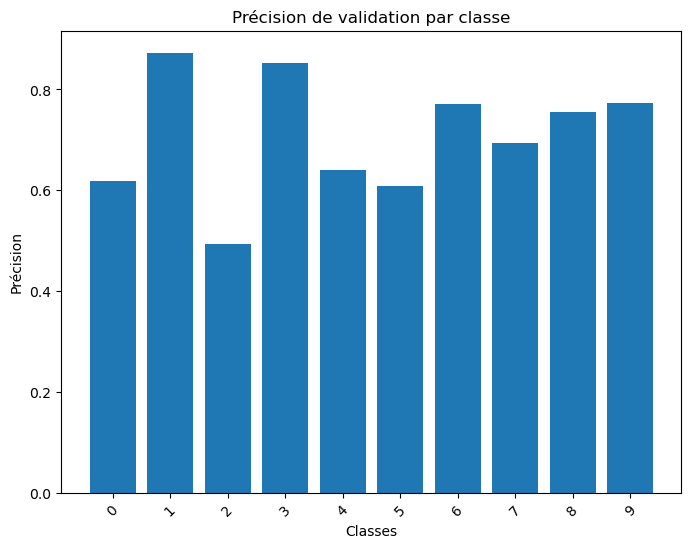

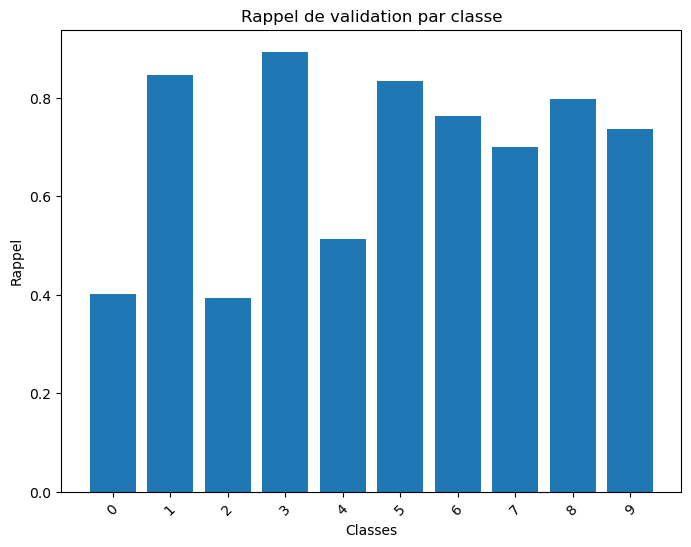

In [140]:
compute_and_display_pr(val_confusion_matrix)

#### Commentaires

La précision est une mesure de l'exactitude des prédictions positives du modèle, elle est ici comprise en tre 0.45 et 0.83 pour l'ensemble des classes . Pour les classes 1 et 3  le score de précision est supérieur à 0.8 ce qui est un bon score.

Le rappel,mesure la capacité du modèle à identifier correctement les échantillons positifs parmi tous les échantillons réellement positifs. Ici le rappel est très inégal car le modèle a su identifier correctement les échantillons positifs des classes 1 et 3 ce qui n'est pas le cas des classes 0 et 2 qui ont un score de 0.4.

Affichage de l'évolution des courbes.

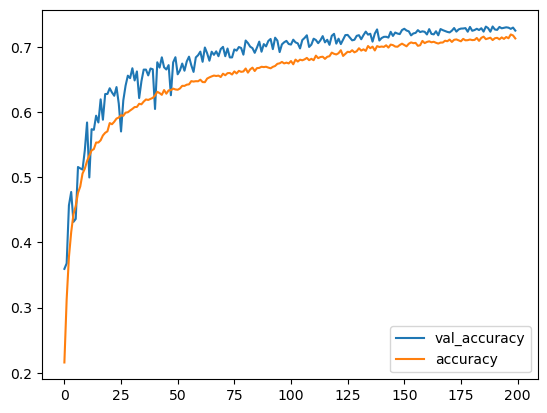

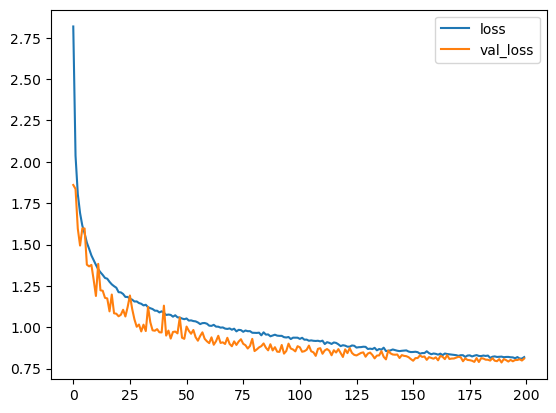

In [120]:
plot_history(file_name="history.csv")

### Commentaires sur les courbes

- Courbes d'accuracy:
    On peut remarquer que la val_accuracy est dans l'ensemble supérieure à l'accuracy, ce qui signifie que le réseau ne sur-apprend pas. Cependant l'accuracy converge vers 0.7 ce qui n'est pas suffisant.
- Courbes de loss:
    De la même manière la courbe de loss de la validation est dans l'ensemble inférieure cependant elle converge aux alentours de 0.8.

### Soumission des tests

In [134]:
test_phase(model)
FileLink(config["output_file"])

116/116 [==============================] - 6s 54ms/step


/kaggle/working/submission.csv

Nous gardons enfin une trace de l'intégralité des configurations nécessaires à l'entraînement du modèle dans le fichier `config.yml`.

In [ ]:
save_config(config, "config.yml")

In [ ]:
!rm -rf ships32/

In [ ]:
print("Nombre de couches : ", len(model.layers))